### Summary, Modeling, and Prediction of Labeled Data

In this notebook, I merge Upworker-provided data labels into the existing merged_cleaned.csv dataset. I then show a series of brief descriptive graphics of the labeled data. 

Following this 

#### 1. Summary of Labeled Data 

Below, I merge data labels (1) having an initial stance and (2) having a follow up using matching pre-assigned hash values in a one-to-one merge. 

What do we want to find out?

Can we predict the labels?
1. Subquestion: Are initial stances different from follow ups?<br>

Probability of a tweet being a stance in the test set. (combine follow-up with the initial stance)


In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import pandas as pd
import numpy as np
import nltk
from wordcloud import WordCloud
from textblob import TextBlob


# Import Matplotlib and Seaborn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

#Import helpful user-defined functions for directories in nb_functions.py
from nb_functions import set_project_root, change_dir

PROJECT_ROOT = set_project_root()

In [2]:
# Read in the labels and hash column for matching, concatenate into one dataset
change_dir(PROJECT_ROOT, '/data/upwork_rater_data') 
col_names = ['floyd_stance','floyd_followup','hash']
df_1 = pd.read_csv('df_u_1_a.csv', usecols=col_names)
df_2 = pd.read_csv('df_u_2_a.csv', usecols=col_names)
df_3 = pd.read_csv('df_u_3_a.csv', usecols=col_names)
df_4 = pd.read_csv('df_u_4_a.csv', usecols=col_names)
df_5 = pd.read_csv('df_u_5_a.csv', usecols=col_names)
df_6 = pd.read_csv('df_u_6_a.csv', usecols=col_names)

df_upwork = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6], ignore_index=True)
df_upwork.info()

      
New Working Directory: ~/data/upwork_rater_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41532 entries, 0 to 41531
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   floyd_stance    41532 non-null  int64 
 1   floyd_followup  41532 non-null  int64 
 2   hash            41532 non-null  object
dtypes: int64(2), object(1)
memory usage: 973.5+ KB


In [3]:
change_dir(PROJECT_ROOT, "/data")

      
New Working Directory: ~/data


In [4]:
# Read in cleaned df, drop floyd_stance and floyd_followup, merge on hash
df_merged_clean = pd.read_pickle('data_merged_clean.pkl')
df_merged_clean.drop(columns=['floyd_stance', 'floyd_followup'], inplace=True)

In [5]:
# It looks like the hash values imported correctly into both dfs.
df_merged_clean['hash'].value_counts()

h12518223719878787108    1
h7187027306473295183     1
h18112544115532282147    1
h10212036739130035012    1
h6327793134288738618     1
                        ..
h15419431695644698169    1
h17786517936449321703    1
h11398402452239760292    1
h116113137195155636      1
h17305019791838734043    1
Name: hash, Length: 41532, dtype: int64

In [6]:
df_upwork['hash'].value_counts()

h15628930011340233499    1
h3307790413826089923     1
h6964003440296525364     1
h4973469486238008171     1
h9175189227924654326     1
                        ..
h57750140664743484       1
h4354376490621076663     1
h5731650468333522909     1
h10186489926792052482    1
h17305019791838734043    1
Name: hash, Length: 41532, dtype: int64

In [7]:
df = pd.merge(df_merged_clean, df_upwork, how='outer', on=['hash'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41532 entries, 0 to 41531
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           41532 non-null  int64  
 1   text               41532 non-null  object 
 2   replies            41532 non-null  int64  
 3   retweets           41532 non-null  int64  
 4   likes              41532 non-null  int64  
 5   quotes             41532 non-null  int64  
 6   media              3432 non-null   object 
 7   source_label       41532 non-null  object 
 8   username           41532 non-null  object 
 9   ceo_account        41532 non-null  int64  
 10  compustat_company  41532 non-null  object 
 11  user_join_date     41532 non-null  object 
 12  user_followers     41532 non-null  int64  
 13  user_friends       41532 non-null  int64  
 14  user_statuses      41532 non-null  int64  
 15  user_favorites     41532 non-null  int64  
 16  user_listed        415

<br><br> 
It appears that the dataframes merged correctly. Let's start looking at basic descriptives on the labeled set. 

First, let's create a "floyd_action" feature that combines the initial stance and any follow-up action. We see that only about 0.7% of the tweets are labeled as stance actions.

Second, looking in more detail at summary statistics, we see that stance tweets have much higher numbers of replies, retweets, and likes than non-stance tweets. They are also more likely to have originated from a CEO account and include links to external webpages than non-stance tweets. Looking at individual punctuation marks, stance tweets are more likely to include \\$ characters and hashtags, but less likely to mention other twitter users, contain emojis, or have non-period punctuation (! or ?). This aligns well with my priors: these stances are meant to be serious and direct, have wide reach (e.g., using common hashtags), and to signal commitment (possibly financial due to the preponderance of \\$ characters). <br><br>

In [8]:
df['floyd_action'] = df['floyd_stance'] + df['floyd_followup']

print(df['floyd_action'].value_counts())

0    41242
1      290
Name: floyd_action, dtype: int64


In [9]:
df[df['floyd_action']==1].describe()

,tweet_id,replies,retweets,likes,quotes,ceo_account,user_followers,user_friends,user_statuses,user_favorites,...,urls_count,mentions_count,hashtags_count,dollar_count,quest_count,exclam_count,emoji_count,floyd_stance,floyd_followup,floyd_action
count,2.900000e+02,290.000000,290.000000,290.000000,290.000000,290.000000,2.900000e+02,290.000000,2.900000e+02,290.000000,...,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.0
mean,1.269504e+18,85.751724,179.244828,815.489655,66.889655,0.062069,1.223315e+06,3809.865517,7.361653e+04,25794.965517,...,0.831034,0.651724,0.382759,0.117241,0.044828,0.024138,0.037931,0.220690,0.779310,1.0
std,1.624000e+15,366.434301,636.667952,3309.786710,598.112899,0.241698,2.841655e+06,10244.648865,2.049012e+05,26121.335468,...,0.712520,0.955451,0.807649,0.332828,0.290669,0.153743,0.224632,0.415428,0.415428,0.0
min,1.265644e+18,0.000000,0.000000,0.000000,0.000000,0.000000,7.310000e+02,0.000000,1.440000e+02,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.268226e+18,0.000000,0.000000,1.250000,0.000000,0.000000,1.605930e+05,274.000000,1.282000e+04,3135.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,1.269029e+18,3.000000,11.500000,42.000000,2.000000,0.000000,2.164020e+05,1097.000000,2.014700e+04,12952.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
75%,1.270884e+18,28.000000,65.500000,230.500000,13.750000,0.000000,9.054380e+05,2545.000000,1.026260e+05,51796.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
max,1.272271e+18,5093.000000,6360.000000,37997.000000,10016.000000,1.000000,2.265206e+07,105648.000000,2.285343e+06,81858.000000,...,2.000000,5.000000,4.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.0


In [10]:
df[df['floyd_action']==0].describe()

,tweet_id,replies,retweets,likes,quotes,ceo_account,user_followers,user_friends,user_statuses,user_favorites,...,urls_count,mentions_count,hashtags_count,dollar_count,quest_count,exclam_count,emoji_count,floyd_stance,floyd_followup,floyd_action
count,4.124200e+04,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,4.124200e+04,41242.000000,4.124200e+04,41242.000000,...,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.0,41242.0,41242.0
mean,1.264010e+18,1.747951,2.979147,16.866495,0.530867,0.004655,2.405774e+06,32069.548979,7.319026e+05,17234.338611,...,0.397750,0.990422,0.144367,0.068062,0.121963,0.232457,0.130668,0.0,0.0,0.0
std,4.146813e+15,28.199421,36.566858,268.387392,8.328189,0.068073,5.348714e+06,41768.777897,9.133817e+05,21289.050638,...,0.584245,0.494121,0.475241,0.454894,0.342241,0.528622,0.499238,0.0,0.0,0.0
min,1.257098e+18,0.000000,0.000000,0.000000,0.000000,0.000000,5.470000e+02,0.000000,1.440000e+02,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.260724e+18,0.000000,0.000000,0.000000,0.000000,0.000000,2.488710e+05,292.000000,8.796400e+04,4986.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,1.263531e+18,0.000000,0.000000,0.000000,0.000000,0.000000,1.082204e+06,9050.000000,1.364240e+05,5282.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,1.267265e+18,1.000000,0.000000,1.000000,0.000000,0.000000,1.603666e+06,42896.000000,1.237612e+06,19922.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,1.272317e+18,3860.000000,2614.000000,27909.000000,621.000000,1.000000,2.265206e+07,105648.000000,2.285343e+06,81858.000000,...,4.000000,13.000000,9.000000,4.000000,4.000000,8.000000,12.000000,0.0,0.0,0.0


In [11]:
action_token_string = ' '.join([' '.join(t) for t in df['text_tokens'][df['floyd_action']==1]])
nonaction_token_string = ' '.join([' '.join(t) for t in df['text_tokens'][df['floyd_action']==0]])

<br><br>
Next, let's look at a few word clouds.  

The word cloud for stance tweets (initial stances and follow-ups) is strikingly different from that of the non-stance tweets. We see words like "racism", "discrimination", and "action" highly represented, compared to the more customer service oriented language in the non-stance cloud. 
<br><br>

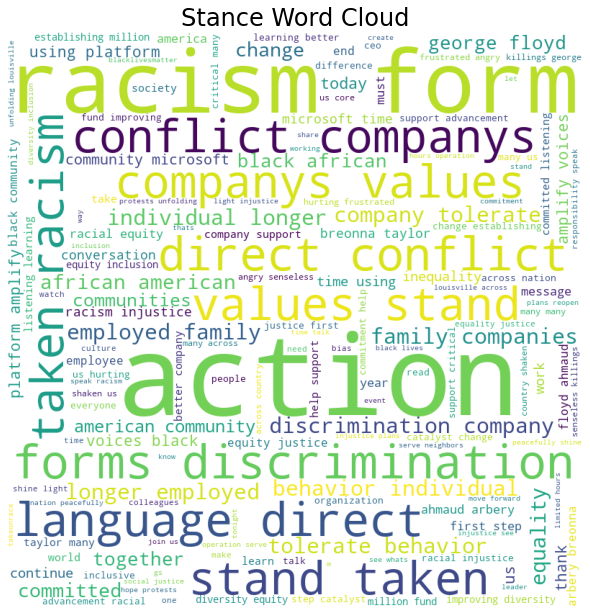

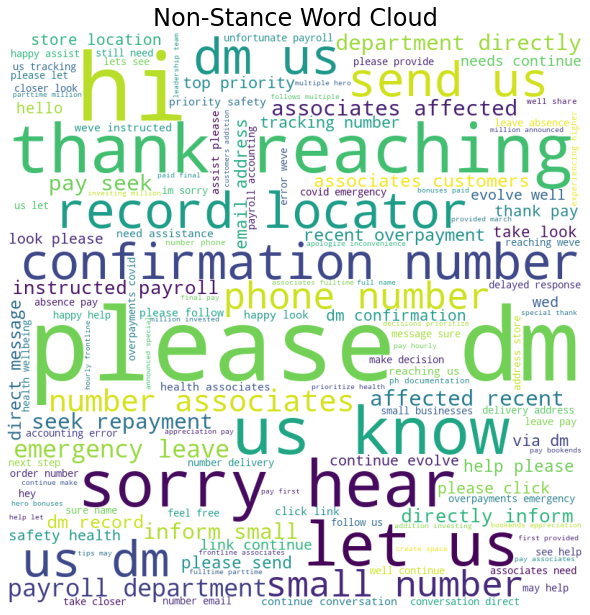

In [12]:
from nb_functions import plot_cloud

action_token_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(action_token_string)
non_action_token_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(nonaction_token_string)

plot_cloud(action_token_wc, "Stance Word Cloud")
plot_cloud(non_action_token_wc, "Non-Stance Word Cloud")


<br><br>
We also see that the average stance tweet tends to use a more neutral, objective tone than more positive, subjective nonstance tweets. These differences, though, are slightly less pronounced than those between the subsamples analyzed in the previous notebooks (e.g., high replies, high likes). 
<br><br>

In [13]:
def return_sntmt(string):
    sntmt = TextBlob(string)
    return sntmt.sentiment.polarity, sntmt.sentiment.subjectivity

print(f'The stance tweet sample polarity is {return_sntmt(action_token_string)[0]} and subjectivity is {return_sntmt(action_token_string)[1]}.')
print(f'The non-stance tweet sample polarity is {return_sntmt(nonaction_token_string)[0]} and subjectivity is {return_sntmt(nonaction_token_string)[1]}.')


The stance tweet sample polarity is 0.0794445109143602 and subjectivity is 0.4140291706246484.
The non-stance tweet sample polarity is 0.17228268708746097 and subjectivity is 0.5245914961307271.


<br><br>
Let's take a more detailed look at some of the more common bigrams for stance and non-stance tweets.

We can see that the most common bigrams in the non-stance sample are mostly focused on customer service communications, with many of them focusing on either requesting more information about a customer order (e.g., record locator, confirmation number) or redirecting the conversation to a private channel (e.g., dm us, send us).

The most common bigrams in the stance sample, by comparison, are directly related to race (e.g., forms discrimination, racism forms) or an appeal to company morality (e.g., values stand, family companies). Interestingly, there are a few bigrams which appear to reference individual firings at firms as well.
<br><br>

In [14]:
stopwords = nltk.corpus.stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer

ct_vec_stance = CountVectorizer(ngram_range=(2,2), stop_words=stopwords)
ct_vec_nonstance = CountVectorizer(ngram_range=(2,2), stop_words=stopwords)

def make_df_ngram(text_col, ct_vec):
    ngrams = ct_vec.fit_transform(text_col)
    ct_values = ngrams.toarray().sum(axis=0)
    vocab = ct_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(ct_values[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0:'frequency', 1:'bigram'})
    return df_ngram


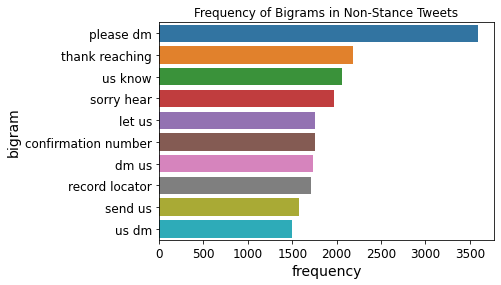

In [15]:
df_ngram_nonstance = make_df_ngram(df['text'][df['floyd_action']==0], ct_vec_nonstance)
ax = sns.barplot(x="frequency", y="bigram", data=df_ngram_nonstance[:10]).set_title('Frequency of Bigrams in Non-Stance Tweets')


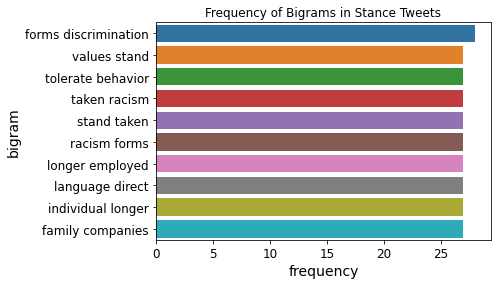

In [42]:
df_ngram_stance = make_df_ngram(df['text'][df['floyd_action']==1], ct_vec_stance)
ax = sns.barplot(x="frequency", y="bigram", data=df_ngram_stance[:10]).set_title('Frequency of Bigrams in Stance Tweets')


#### 2. Modeling and Classification 

At this point, we have a good sense of which words are associated with stance and non-stance tweets. In the next section, I train a series of machine learning classifier algorithms to classify tweets as stance tweets or non-stance tweets.

[Main Reference](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#working-with-text-data)

[Pipeline for classifiers](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#building-a-pipeline)


#### 3. Evaluation Metrics

As shown above, political stance tweets are rare events in this dataset (about 0.7% of all tweets), so our data is imbalanced. This makes the choice of metric challenging, since classifiers with non-predictive value (say, classifying all instances in the full dataset as "no stance") would yield high accuracy metrics. So relying on accuracy (true positives + true negatives over all classified outputs) would be misleading in this setting. 

To understand potential severity of Type I and Type II errors, let's frame the business problem that a "stance classifier" would aim to resolve. Let's assume that a company uses a tweet classifier to determine when it should take a stance based on the behavior of its peers. For simplicity, let's assume there is an underlying benefit to  coordination (and cost to anti-coordination) among peers. For example, if your closest peers are going to take a stance, then you want to take a stance to avoid being labeled in the media as "not caring" about the issue. Conversely, if you take a stance while your peers fail to take a stance, then you subject yourself to sole criticism for taking an stance that is unpopular among your peers. Organizational researchers have shown that this ["wait then imitate"](https://journals.sagepub.com/doi/abs/10.2189/asqu.53.3.460?casa_token=RimO4bscEWsAAAAA:n32Tb-FI6baPzBcKgGkJKB9-Hj5A4cbJnZSnVGbndVI1_VULna0VrIiW4ztEr6eOn9w95rKiXHgErg) strategy is common among most large companies facing contentious social issues.

Let's think about classification errors and their impact on decision making in this problem. If the company's algorithm incorrectly classifies its peers' recent tweets as taking a stance (i.e., detects false positives), then a decision maker in the company who takes a stance per incorrect model recommendations risks making the company a clear target for stakeholder responses. Being a first mover in stance taking can have serious repercussions, even without faulty inference. For example, Dick's Sporting Goods was a "first mover" among hunting retailers to stop selling assault rifles in their store following the Parkland Shooting in 2018. This stance led to conservative customers boycotting the store and [at least 62 conservative employees leaving the company in protest](https://www.npr.org/2019/02/12/691999347/soul-searching-after-parkland-dicks-ceo-embraces-tougher-stance-on-guns). 

Conversely, if the company's algorithm incorrectly classifies peers' tweets as not taking a stance when they actually are (i.e., returns false negatives), then a decision maker in the company may decide not to take a stance per model recommendations. Not taking a stance on certain issues may also lead to significant stakeholder and activist pushback. For example, in mid-2020, companies from Adidas to Coca-Cola pulled ads from Facebook for failing to take a meaningful stance to limit hate speech on their site. In total, these companies represented [hundreds of millions of dollars](https://www.nytimes.com/2020/06/26/business/media/Facebook-advertising-boycott.html) in yearly advertising revenue.

In sum, unlike many situations with imbalanced classes (e.g., insurance fraud), Type I and Type II errors are arguably equally important without knowing more information on domain-specific aspects (e.g., company, political issue, etc.). 

<br><br>
Given the imbalance in classes, and given the roughly equal importance of Type I and Type II errors, my preferred evaluation metric will be **Matthew's correlation coefficient/ROC AUC**. (SAY WHY. https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/ https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc Precision, recall, and F1 as well... also see Akosa SAS paper in Zotero).

That being said, different companies and industries may have different use cases (e.g., companies in industries without a history of corporate stance-taking may overweight the importance of avoiding false positives). Given these company-by-company contingencies, I will also report a set of other commonly-used metrics as well.
<br><br>